# Lab 3 - Part 1: Classification and Grid Search (33 marks)
### Due Date: Monday, March 13 at 12pm

Author: *YOUR NAME*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The purpose of this portion of the assignment is to practice following the grid-search workflow: 
- Split data into training and test set
- Use the training portion to find the best model using grid search and cross-validation
- Retrain the best model
- Evaluate the retrained model on the test set

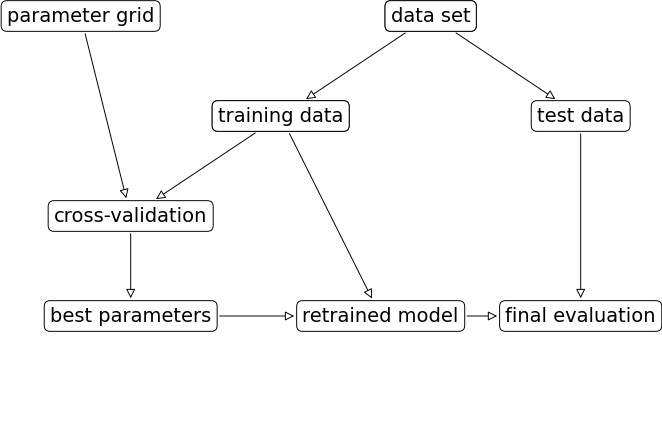

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions (2 marks)

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score



def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, return_estimator=True)
    training_score = scores['train_score'].mean()
    testing_score = scores['test_score'].mean()
    return training_score, testing_score    

In [4]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    
    print(grid_search.best_params_)
    print("training score= {:.3f}; validation score={:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
                                                                  grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [5]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [6]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(mat, 
                xticklabels=labels,  
                yticklabels=labels, 
                square=True, annot=True, cbar=False, 
                fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data (2 marks)
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`

Print shape and type of `X`, `y`

In [7]:
# TODO: Add data loading code
from yellowbrick.datasets.loaders import load_mushroom
X, y = load_mushroom()
# Print shape of X and y
print("X shape: ", X.shape, "y shape: ", y.shape)

# Print type of X and y
print("X type: ", type(X), "y type: ", type(y))

X shape:  (8123, 3) y shape:  (8123,)
X type:  <class 'pandas.core.frame.DataFrame'> y type:  <class 'pandas.core.series.Series'>


In [8]:
X

,shape,surface,color
0,convex,smooth,yellow
1,bell,smooth,white
2,convex,scaly,white
3,convex,smooth,gray
4,convex,scaly,yellow
...,...,...,...
8118,knobbed,smooth,brown
8119,convex,smooth,brown
8120,flat,smooth,brown
8121,knobbed,scaly,brown


In [9]:
y

0          edible
1          edible
2       poisonous
3          edible
4          edible
          ...    
8118       edible
8119       edible
8120       edible
8121    poisonous
8122       edible
Name: target, Length: 8123, dtype: object

## 2. Preprocessing (4 marks)
In this dataset, all features are discrete and nominal and need to be encoded. We will use a `OneHotEncoder`

The target vector is discrete and nominal as well and contains string labels. While sklearn is OK using string labels in target vectors, you will use a `LabelEncoder` explicitly to convert strings to integers and keep the encoder to translate between the two representations

### 2.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a variable `X_enc`. Use `sparse=False`. Print shape of `X_enc`

In [10]:
# TODO: Add OneHotEncoder here
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
X_enc = ohe.fit_transform(X)
print("X_enc shape: ", X_enc.shape)

X_enc shape:  (8123, 20)


### 2.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a variable `y_enc`

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object

In [11]:
# TODO: Add LabelEncoder here
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("y_enc shape: ", y_enc.shape)
print("Label encoder classes", le.classes_)

y_enc shape:  (8123,)
Label encoder classes ['edible' 'poisonous']


## 3. Create training and test sets (1 mark)
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets

In [12]:
# TODO: Add train_test_split() here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, random_state=37, test_size=0.2)
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  (6498, 20) y_train shape:  (6498,)


## 4. Compare models using cross-validation (4 marks)
Create a list containing `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- Compute the **f1 score** using `get_classifier_cv_score()` with the 7-fold cross-validation defined above with `X_train` and `y_train` as arguments
- Print the models' training and validation scores with **3 decimal places**

In [13]:
# TODO: Add cross-validation comparison here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Create a list of all the models
models = [LogisticRegression(), SVC(), BernoulliNB(), RandomForestClassifier(random_state=55), GradientBoostingClassifier(random_state=56)]

for model in models:
    f1_training_score, f1_testing_score = get_classifier_cv_score(model, X_train, y_train, scoring='f1')
    print("Model: ", model.__class__.__name__)
    print("Training F1 score: {:.3f}".format(f1_training_score))
    print("Testing F1 score: {:.3f}".format(f1_testing_score))
    print()

Model:  LogisticRegression
Training F1 score: 0.663
Testing F1 score: 0.664

Model:  SVC
Training F1 score: 0.691
Testing F1 score: 0.678

Model:  BernoulliNB
Training F1 score: 0.614
Testing F1 score: 0.613

Model:  RandomForestClassifier
Training F1 score: 0.692
Testing F1 score: 0.678

Model:  GradientBoostingClassifier
Training F1 score: 0.702
Testing F1 score: 0.692



## 5. Hyperparameter tuning using grid search (8 marks)

The inital cross-validation above gives us an idea of how algorithms perfom using their default hyperparameters

Next, we will try and improve one model by tuning its hyperparameters using grid search

### 5.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(n_estimators=300, random_state=55)`:

- Set the number of trees `n_estimators=300` for all evaluations
- Grid search using 7-fold cross-validation and `f1` as the scoring function 
- Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores  or -1 works well

Use the following hyperparameters and values:
- `'max_depth': [3, 5, 8]`
- `'max_features': [0.3, 0.5, 0.7, 0.9]`

From sklearn help:
> - max_depth: The maximum depth of the tree
> - max_features: If float, then max_features is a fraction and max(1, int(max_features * n_features)) features are considered at each split


Use the `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results

In [14]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV

max_depth = [3,5,8]
max_features = [0.3, 0.5, 0.7, 0.9]
gs = GridSearchCV(RandomForestClassifier(n_estimators= 300, random_state=55),
                  param_grid={'max_depth': max_depth, 'max_features': max_features},
                  scoring='f1',
                  cv=7,
                  return_train_score=True,
                  n_jobs=-1)

In [15]:
# TODO: Perform the grid search by calling fit() with X_train and y_train
gs.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=RandomForestClassifier(n_estimators=300,
                                              random_state=55),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'max_features': [0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, scoring='f1')

In [16]:
# TODO: Call print_grid_search_result() to print the results
print_grid_search_result(gs)

{'max_depth': 5, 'max_features': 0.7}
training score= 0.719; validation score=0.716


### *Question 1:* What is the validation score of the best model? Which models in Section 4 does it outperform?

*ADD YOUR ANSWER HERE*


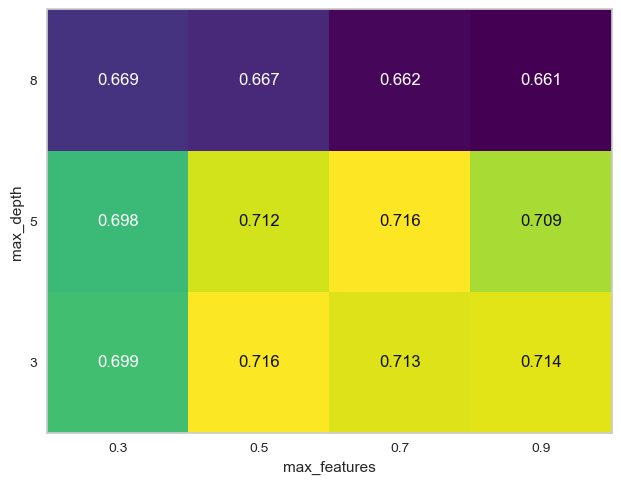

In [17]:
# TODO: Call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(gs)

### *Question 2:* Where in the hyperparameter ranges does the maximum occur? Would you need to adjust the hyperparameter ranges to find a better model?

Based on the results of the grid search, the highest F1 score is achieved when the `max_depth` hyperparameter is set to 5 and the `max_features` hyperparameter is set to 0.7. Since the maximum is in the middle of our grid search graph we are not required to adjust the hyperparameter ranges to find a better model.

## 6. Re-train best model (2 marks)
Re-train the best `RandomForestClassifier()` from the grid search above on the training dataset `X_train` and `y_train`

In [18]:
#TDOD: Re-train best random forest classifier
max_depth = gs.best_params_['max_depth']
max_features = gs.best_params_['max_features']
best_model = RandomForestClassifier(n_estimators=300, max_depth=max_depth, max_features=max_features, random_state=55)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

## 7. Evaluate using test data (4 marks)

Using the retrained model and the test dataset `X_test` and `y_test`:
- plot the confusion matrix using the `plot_confusion_matrix()` function defined above
- print the classification report

Make sure the plot has class labels and a title

### 7.1 Confusion matrix and classification report

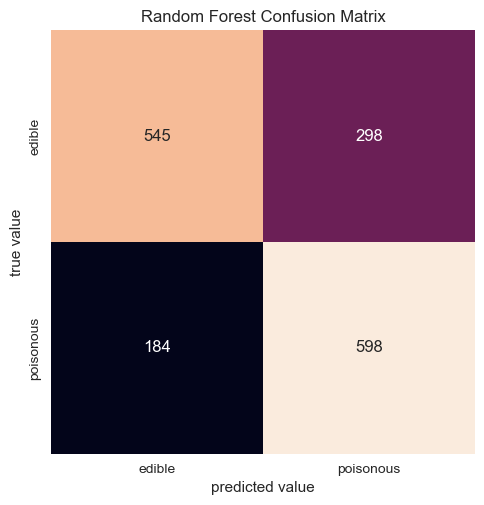

In [19]:
#TODO: call plot_confusion_matrix(), use LabelEncoder classes_ to get labels
plot_confusion_matrix(y_test, y_pred_best, le.classes_, "Random Forest Confusion Matrix")

### 7.2 Classification report

In [20]:
#TODO: print classification report using default threshold
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

              precision    recall  f1-score   support

      edible       0.75      0.65      0.69       843
   poisonous       0.67      0.76      0.71       782

    accuracy                           0.70      1625
   macro avg       0.71      0.71      0.70      1625
weighted avg       0.71      0.70      0.70      1625



### *Question 3:* What are the precision, recall and accuracy for the positive class on the test set?

For the positive class on the test set the precision, recall, and accuracy are 0.67, 0.76, 0.70 respectively.

### *Question 4:* How many false negatives and false positives does the model produce on the test set?

False positives: 298

False negatives: 184

## 8. Conclusion (4 marks)

In the conclusion, comment on the following items and use data to support your findings:
1. In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
1. In the classification of edible vs poisonous mushrooms, why is high recall desired?
1. Reflect on the usefulness of this model if it would be put into production and propose ways to improve the model and/or application

1. False positive means that we said it was poisonous when it was not. False negative means that it was not poisonous when it was. The consequence of a false positive is that we may not consume a mushroom in fear that it may be poisonous while the consequence of a false negative is that we may consume a mushrooms that we believe is safe but actually ends up harming us since it is poisonous.

2. High recall is desired in this case of edible vs poisonous mushrooms because recall increases the number of true positives and consequently the number of false positives predicted by the model will increase and the number of false negatives predicted by the model will decrease. It is desirable to decrease the number of false negatives because it is more dangerous to consume a poisonous mushroom than to not consume a mushroom that is actually edible.

3. This model is useful if it is put into production because it can help people identify whether a mushroom is edible or poisonous. However, since the model is not perfect, it is possible that it may misclassify a mushroom as edible when it is actually poisonous. The predictions can be improved by collecting more data and features and training the model on a larger dataset. This will allow our model to learn the patterns in the data better and make more accurate predictions.

## 9. Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment 

Can include thoughts from Lab 3-2 as well

I enjoyed the process of instantiating my models, cross validating and performing grid search in the same pipeline and using that process to determine the best model. I also enjoyed the process of repeating a similar process to get silhouette scores for our clustering. I found the procedure easy to follow and very informative.